In [10]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [20]:
# set number of assets (= number of qubits)
num_assets = 8
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2019, 1, 1),
    end=datetime.datetime(2020, 12, 30),
    seed=seed,
)
data.run()
mu    = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

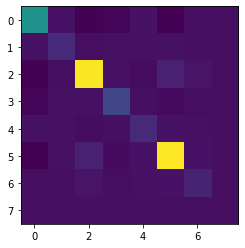

In [21]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [22]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000693213649 x_0 - 0.000919714004 x_1 + 0.003441175210 x_2
      + 0.000636978925 x_3 - 0.000372205348 x_4 - 0.002657386205 x_5
      - 0.000210321094 x_6 + [ 0.001500009555 x_0^2 + 0.000032831436 x_0*x_1
      - 0.000231886714 x_0*x_2 - 0.000146564792 x_0*x_3 + 0.000048651013 x_0*x_4
      - 0.000270380521 x_0*x_5 + 0.000003211428 x_0*x_6 + 0.000244281494 x_1^2
      - 0.000022025595 x_1*x_2 + 0.000010925432 x_1*x_3 + 0.000016670305 x_1*x_4
      + 0.000021827639 x_1*x_5 - 0.000015990530 x_1*x_6 + 0.003057445680 x_2^2
      + 0.000023620146 x_2*x_3 - 0.000062020547 x_2*x_4 + 0.000307951750 x_2*x_5
      + 0.000070452974 x_2*x_6 + 0.000534029666 x_3^2 - 0.000007962413 x_3*x_4
      - 0.000077302773 x_3*x_5 - 0.000043673836 x_3*x_6 + 0.000250845292 x_4^2
      + 0.000053663891 x_4*x_5 + 0.000010317304 x_4*x_6 + 0.003076946926 x_5^2
      + 0.000043767768 x_5*x_6 + 0.

In [23]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [24]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 0. 1. 1. 1. 0.], value -0.0022

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 1 1 1 0]	-0.0022		1.0000
[1 1 1 1 1 1 1 1]	16.2293		0.0000
[1 1 1 1 0 0 1 0]	1.0190		0.0000
[0 0 1 1 1 0 1 0]	0.0055		0.0000
[1 1 0 1 1 0 1 0]	1.0139		0.0000
[0 1 0 1 1 0 1 0]	-0.0003		0.0000
[1 0 0 1 1 0 1 0]	0.0005		0.0000
[0 0 0 1 1 0 1 0]	1.0146		0.0000
[1 1 1 0 1 0 1 0]	1.0179		0.0000
[0 1 1 0 1 0 1 0]	0.0038		0.0000
[1 0 1 0 1 0 1 0]	0.0046		0.0000
[0 0 1 0 1 0 1 0]	1.0187		0.0000
[1 1 0 0 1 0 1 0]	-0.0011		0.0000
[0 1 0 0 1 0 1 0]	1.0129		0.0000
[1 0 0 0 1 0 1 0]	1.0138		0.0000
[0 0 0 0 1 0 1 0]	4.0561		0.0000
[0 1 1 1 0 0 1 0]	0.0050		0.0000
[0 1 1 1 1 0 1 0]	1.0188		0.0000
[1 0 1 1 0 0 1 0]	0.0056		0.0000
[0 0 1 1 0 0 1 0]	1.0199		0.0000
[1 1 0 1 0 0 1 0]	-0.0000		0.0000
[0 1 0 1 0 0 1 0]	1.0141		0.0000
[1 0 0 1 0 0 1 0]	1.0149		0.0000
[0 0 0 1 0 0 1 0]	4.0572		0.0000
[1 1 1 0 

In [25]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 0. 1. 1. 0. 1.], value -0.0021

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 1 0 0 0 0]	0.0050		0.2280
[0 0 0 0 1 1 1 1]	-0.0014		0.2204
[1 1 0 1 1 0 0 0]	-0.0001		0.1850
[0 0 1 0 0 1 1 1]	0.0039		0.1768
[1 0 1 0 0 1 0 1]	0.0038		0.0549
[1 0 0 0 1 1 0 1]	-0.0014		0.0475
[0 1 0 1 1 0 1 0]	-0.0003		0.0467
[0 1 1 1 0 0 1 0]	0.0050		0.0398
[1 0 1 0 1 1 0 1]	1.0177		0.0001
[1 0 0 0 0 1 0 1]	1.0129		0.0001
[0 1 0 1 0 0 1 0]	1.0141		0.0001
[1 1 0 1 0 0 1 0]	-0.0000		0.0001
[1 1 0 1 1 0 1 0]	1.0139		0.0001
[0 1 1 1 1 0 1 0]	1.0188		0.0000
[1 1 1 1 0 0 1 0]	1.0190		0.0000
[1 0 1 0 0 1 1 1]	1.0179		0.0000
[1 0 0 0 1 1 1 1]	1.0126		0.0000
[0 0 1 0 0 1 0 1]	1.0181		0.0000
[1 1 0 1 1 0 0 1]	1.0140		0.0000
[0 0 1 0 0 1 1 0]	1.0180		0.0000
[1 0 0 0 0 1 1 1]	-0.0013		0.0000
[1 1 1 1 1 0 0 0]	1.0188		0.0000
[0 1 1 0 0 1 0 1]	0.0032		0.0000
[1 1 1 1 0 0 0 1]	1.0191		0.0000
[0 1 0 0

In [26]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 0. 1. 1. 1. 0.], value -0.0022

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 1 1 1 0]	-0.0022		0.0145
[1 1 0 0 1 1 0 0]	-0.0022		0.0145
[0 1 0 0 1 1 0 1]	-0.0021		0.0145
[1 1 0 0 0 1 1 0]	-0.0021		0.0145
[0 1 0 0 0 1 1 1]	-0.0020		0.0145
[1 1 0 0 0 1 0 1]	-0.0020		0.0145
[1 0 0 0 1 1 1 0]	-0.0015		0.0144
[0 0 0 0 1 1 1 1]	-0.0014		0.0144
[1 0 0 0 1 1 0 1]	-0.0014		0.0144
[1 0 0 0 0 1 1 1]	-0.0013		0.0144
[0 1 0 1 1 1 0 0]	-0.0013		0.0144
[1 1 0 1 0 1 0 0]	-0.0012		0.0144
[0 1 0 0 1 0 1 1]	-0.0012		0.0144
[0 1 0 1 0 1 1 0]	-0.0012		0.0144
[0 1 0 1 0 1 0 1]	-0.0010		0.0144
[1 1 0 0 1 0 1 0]	-0.0011		0.0144
[1 1 0 0 1 0 0 1]	-0.0009		0.0144
[1 1 0 0 0 0 1 1]	-0.0009		0.0144
[1 0 0 1 1 1 0 0]	-0.0006		0.0144
[0 0 0 1 1 1 1 0]	-0.0006		0.0144
[1 0 0 1 0 1 1 0]	-0.0005		0.0144
[0 0 0 1 1 1 0 1]	-0.0005		0.0144
[1 0 0 1 0 1 0 1]	-0.0004		0.0144
[0 0 0 1 0 1 1 1]	-0.000

In [27]:
import qiskit.tools.jupyter

%qiskit_version_table
